## 5 语言模型

一段自然语言文本可以看作是一个离散时间序列，给定一个长度为T的词的序列$w_1, w_2,\ldots, w_T$，语言模型的目标就是评估该序列是否合理，即计算该序列的概率：
$$P(w_1, w_2,\ldots, w_T)$$

下面介绍的是基于统计的语言模型,主要是n元语法(n-gram)

### 5.1 基础介绍

假设$w_1, w_2,\ldots, w_T$中的每个词是依次生成的，就有

$$\begin{align*}
P(w_1, w_2, \ldots, w_T)
&= \prod_{t=1}^T P(w_t \mid w_1, \ldots, w_{t-1})\\
&= P(w_1)P(w_2 \mid w_1) \cdots P(w_T \mid w_1w_2\cdots w_{T-1})
\end{align*}$$

例如, 一段含有4个词的文本序列的概率
$$P(w_1, w_2, w_3, w_4) =  P(w_1) P(w_2 \mid w_1) P(w_3 \mid w_1, w_2) P(w_4 \mid w_1, w_2, w_3)$$

**语言模型的参数就是词的概率以及给定前几个词情况下的条件概率。**


设设训练数据集为一个大型文本语料库，如维基百科的所有条目，词的概率可以通过该词在训练数据集中的相对词频来计算，例如，的概率可以计算为：$$\hat P(w_1) = \frac {n(w_1)}{n} $$

其中$n(w_1)$为语料库中以$w_1$作为第一个词的文本的数量，$n$为语料库中文本的总数量.

类似的，给定$w_1$情况下，$w_2$的条件概率可以计算为：
$$\hat P(w_2|w_1) = \frac {n(w_1, w_2)}{n(w_1)}$$
其中$n(w_1, w_2)$为语料库中以$w_1$作为第一个词，$w_2$作为第二个词的文本的数量

### 5.2 n元语法

序列长度增加，计算和存储多个词共同出现的概率的复杂度会呈指数级增加。$n$元语法通过马尔可夫假设简化模型，马尔科夫假设是指一个词的出现只与前面$n$个词相关，即$n$阶马尔可夫链（Markov chain of order $n$），如果$n=1$，那么有$P(w_3 \mid w_1, w_2) = P(w_3 \mid w_2)$。基于$n-1$阶马尔可夫链，我们可以将语言模型改写为



$$P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^T P(w_t \mid w_{t-(n-1)}, \ldots, w_{t-1})$$


以上也叫$n$元语法（$n$-grams），它是基于$n - 1$阶马尔可夫链的概率语言模型。例如，当$n=2$时，含有4个词的文本序列的概率就可以改写为：


$$
\begin{align*}
P(w_1, w_2, w_3, w_4)
&= P(w_1) P(w_2 \mid w_1) P(w_3 \mid w_1, w_2) P(w_4 \mid w_1, w_2, w_3)\\
&= P(w_1) P(w_2 \mid w_1) P(w_3 \mid w_2) P(w_4 \mid w_3)
\end{align*}
$$


当$n$分别为1、2和3时，我们将其分别称作一元语法（unigram）、二元语法（bigram）和三元语法（trigram）。例如，长度为4的序列$w_1, w_2, w_3, w_4$在一元语法、二元语法和三元语法中的概率分别为


$$
\begin{aligned}
P(w_1, w_2, w_3, w_4) &=  P(w_1) P(w_2) P(w_3) P(w_4) ,\\
P(w_1, w_2, w_3, w_4) &=  P(w_1) P(w_2 \mid w_1) P(w_3 \mid w_2) P(w_4 \mid w_3) ,\\
P(w_1, w_2, w_3, w_4) &=  P(w_1) P(w_2 \mid w_1) P(w_3 \mid w_1, w_2) P(w_4 \mid w_2, w_3) .
\end{aligned}
$$


当$n$较小时，$n$元语法往往并不准确。例如，在一元语法中，由三个词组成的句子“你走先”和“你先走”的概率是一样的。然而，当$n$较大时，$n$元语法需要计算并存储大量的词频和多词相邻频率。

思考：$n$元语法可能有哪些缺陷？

1. 参数空间过大
2. 数据稀疏

### 5.3 语言模型数据集

读取数据集(这里读取的是本地周杰伦的歌词)

In [41]:
#虽然文本编码是UTF8, 但是因为是中文,必须加上读取编码方式,否则报错
with open("./jaychou_lyrics.txt", encoding='utf-8') as f:
    corpus_chars = f.read()
print(len(corpus_chars))
print(corpus_chars[:40])

#去除Enter=\n\r
corpus_chars = corpus_chars.replace('\n', ' ').replace('\r', ' ')
corpus_chars = corpus_chars[:10000]
print('去除Enter之后\n',corpus_chars[:40])

63282
想要有直升机
想要和你飞到宇宙去
想要和你融化在一起
融化在宇宙里
我每天每天每
去除Enter之后
 想要有直升机 想要和你飞到宇宙去 想要和你融化在一起 融化在宇宙里 我每天每天每


建立字符索引

In [42]:
idx_to_char = list(set(corpus_chars))#去重,索引到字符的映射
char_to_idx = {char: i for i,char in enumerate(idx_to_char)}#字符到索引的映射
vocab_size = len(char_to_idx)
print(vocab_size)

#将每个字符转换为索引, 就是将数据中的中文 数字化
corpus_indices = [char_to_idx[char] for char in corpus_chars]
sample = corpus_indices[:20]
print('chars:', ''.join([idx_to_char[idx] for idx in sample]))
print('indices:', sample)

1027
chars: 想要有直升机 想要和你飞到宇宙去 想要和
indices: [745, 642, 393, 29, 908, 54, 996, 745, 642, 604, 628, 348, 205, 603, 340, 776, 996, 745, 642, 604]


### 5.4 时序数据采样
在训练中我们需要每次随机读取小批量样本和标签。与之前章节的实验数据不同的是，时序数据的一个样本通常包含连续的字符。假设时间步数为5，样本序列为5个字符，即“想”“要”“有”“直”“升”。该样本的标签序列为这些字符分别在训练集中的下一个字符，即“要”“有”“直”“升”“机”，即$X$=“想要有直升”，$Y$=“要有直升机”。

现在我们考虑序列“想要有直升机，想要和你飞到宇宙去”，如果时间步数为5，有以下可能的样本和标签：
* $X$：“想要有直升”，$Y$：“要有直升机”
* $X$：“要有直升机”，$Y$：“有直升机，”
* $X$：“有直升机，”，$Y$：“直升机，想”
* ...
* $X$：“要和你飞到”，$Y$：“和你飞到宇”
* $X$：“和你飞到宇”，$Y$：“你飞到宇宙”
* $X$：“你飞到宇宙”，$Y$：“飞到宇宙去”

可以看到，如果序列的长度为$T$，时间步数为$n$，那么一共有$T-n$个合法的样本，但是这些样本有大量的重合，我们通常采用更加高效的采样方式。我们有两种方式对时序数据进行采样，分别是随机采样和相邻采样。

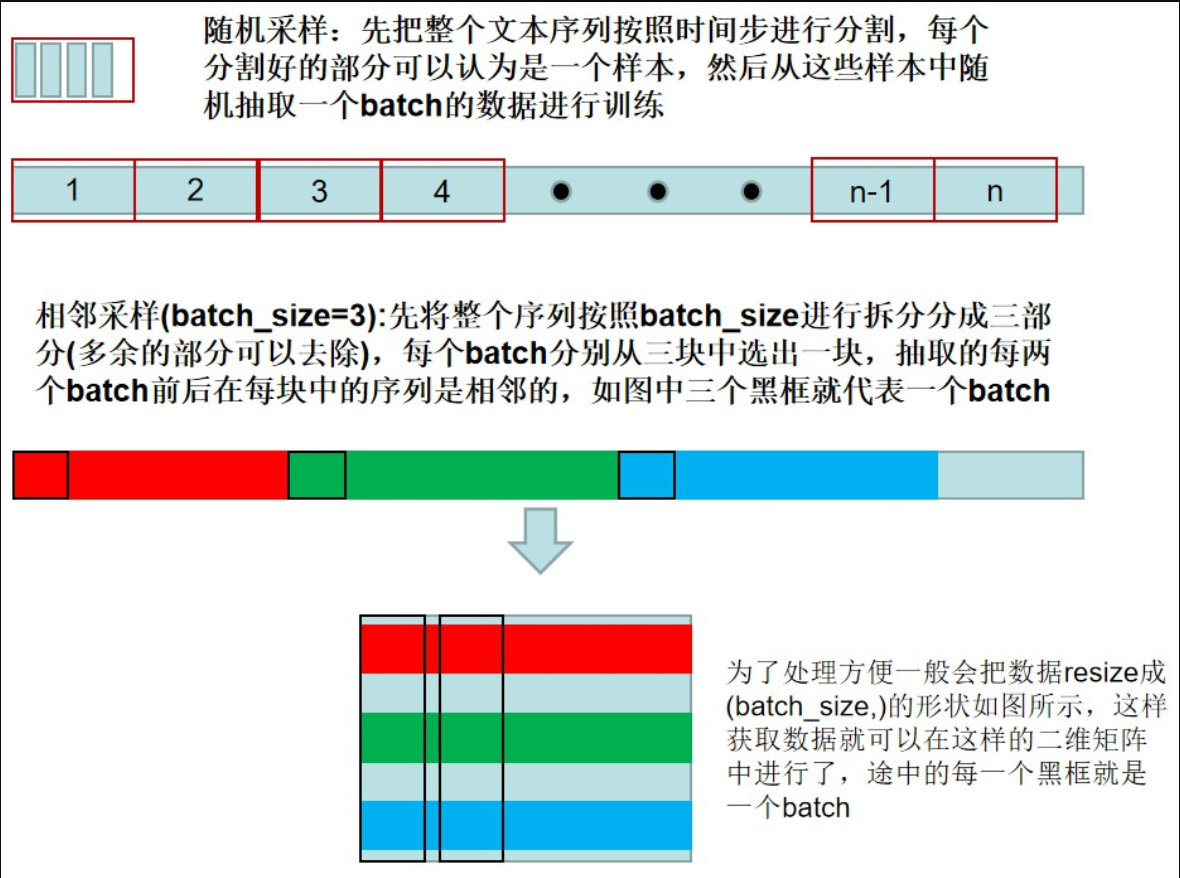

####  5.4.1 随机采样

下面的代码每次从数据里随机采样一个小批量。其中批量大小`batch_size`是每个小批量的样本数，`num_steps`是每个样本所包含的时间步数。
在随机采样中，每个样本是原始序列上任意截取的一段序列，相邻的两个随机小批量在原始序列上的位置不一定相毗邻。

In [46]:
import torch
import random
def data_iter_random(corpus_indices, batch_size, num_steps, device=None):
    #计算样本的数量
    num_examples = (len(corpus_indices) - 1) // num_steps
    #计算每个样本第一个元素所对应的索引
    example_indices = [i * num_steps for i in range(num_examples)]
    random.shuffle(example_indices)#打乱顺序
    
    def _data(i):
        return corpus_indices[i : i+num_steps]
    if(device is None):
        device = torch.device('cuda' if(torch.cuda.is_available()) else 'cpu')
    for i in range(0, num_examples, batch_size):
        #每次选出batch_size个随机样本
        batch_indices = example_indices[i: i+batch_size] # 当前batch的各个样本的首字符的下标
        X = [_data(j) for j in batch_indices ]
        Y = [_data(j+1) for j in batch_indices ]
        yield torch.tensor(X, device=device), torch.tensor(Y, device=device)

In [54]:
my_seq = list(range(30))
for X, Y in data_iter_random(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y, '\n')

X:  tensor([[18, 19, 20, 21, 22, 23],
        [ 6,  7,  8,  9, 10, 11]], device='cuda:0') 
Y: tensor([[19, 20, 21, 22, 23, 24],
        [ 7,  8,  9, 10, 11, 12]], device='cuda:0') 

X:  tensor([[ 0,  1,  2,  3,  4,  5],
        [12, 13, 14, 15, 16, 17]], device='cuda:0') 
Y: tensor([[ 1,  2,  3,  4,  5,  6],
        [13, 14, 15, 16, 17, 18]], device='cuda:0') 



####  5.4.2 相邻采样

在相邻采样中，相邻的两个随机小批量在原始序列上的位置相毗邻。

In [55]:
def data_iter_consecutive(corpus_indices, batch_size, num_steps, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    corpus_len = len(corpus_indices) // batch_size * batch_size  # 保留下来的序列的长度
    corpus_indices = corpus_indices[: corpus_len]  # 仅保留前corpus_len个字符
    indices = torch.tensor(corpus_indices, device=device)
    indices = indices.view(batch_size, -1)  # resize成(batch_size, )
    batch_num = (indices.shape[1] - 1) // num_steps
    for i in range(batch_num):
        i = i * num_steps
        X = indices[:, i: i + num_steps]
        Y = indices[:, i + 1: i + num_steps + 1]
        yield X, Y

In [57]:
for X, Y in data_iter_consecutive(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y, '\n')

X:  tensor([[ 0,  1,  2,  3,  4,  5],
        [15, 16, 17, 18, 19, 20]], device='cuda:0') 
Y: tensor([[ 1,  2,  3,  4,  5,  6],
        [16, 17, 18, 19, 20, 21]], device='cuda:0') 

X:  tensor([[ 6,  7,  8,  9, 10, 11],
        [21, 22, 23, 24, 25, 26]], device='cuda:0') 
Y: tensor([[ 7,  8,  9, 10, 11, 12],
        [22, 23, 24, 25, 26, 27]], device='cuda:0') 



## 5.5 课后作业



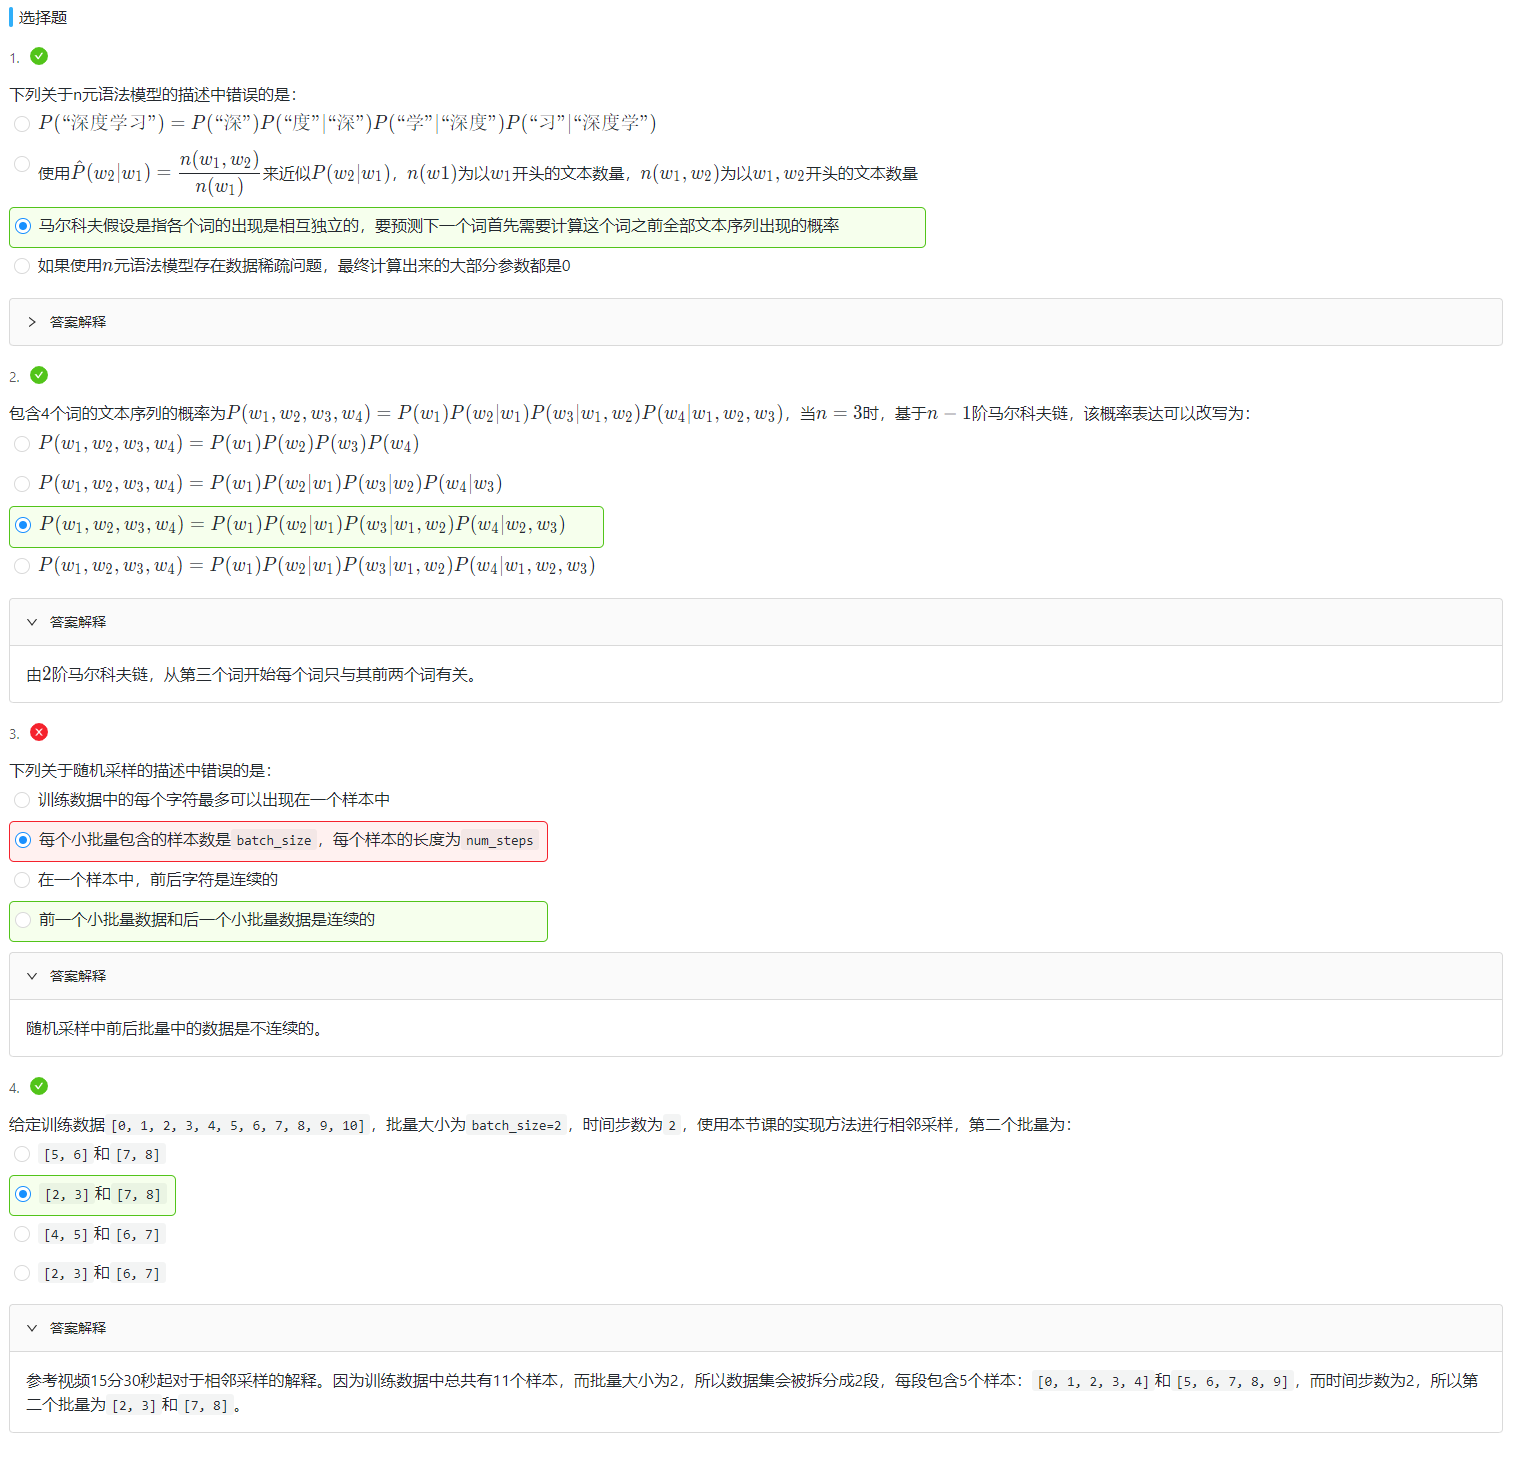

In [63]:
for X, Y in data_iter_consecutive([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], batch_size=2, num_steps=2):
    print('X: ', X, '\nY:', Y, '\n')

X:  tensor([[0, 1],
        [5, 6]], device='cuda:0') 
Y: tensor([[1, 2],
        [6, 7]], device='cuda:0') 

X:  tensor([[2, 3],
        [7, 8]], device='cuda:0') 
Y: tensor([[3, 4],
        [8, 9]], device='cuda:0') 

